# Main Question: 

**How can we predict PERFORMANCE of a movie?**

In this project, we will be trying to predict the performance of a movie with help from various datasets. We hope to extract relevant data, clean our gathered data set and perform data exploration to gain some important insights. We will then attempt to use a machine learning model to answer our question. 


Firstly, we have to clearly define our question. What consitutes a "good" performance of a movie? We can say that a movie performed well if it's movie ratings (given by critics) were high. We could also say that the movie performed well if it made alot of profits!

---
## Data Extraction

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import requests
import json
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import altair as alt
import pandas as pd
sb.set() # set the default Seaborn style for graphics

In [ ]:
movieData = pd.read_csv("Bigger_Data.csv")

movieData=movieData[movieData['imdb_id'].notnull()] #dropping all the null IMBD ID values from the TMBD set

print(len(movieData["imdb_id"])) #So that we can know how much movies we can extract from OMBD dataset

In [ ]:
headers = {'user-agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36"
} #Set user agent, so that our server appears to be a human requesting for access to the website. Certain websites
#might block what seems to be an automated response.

ombdList=[]
for i in range(1000):
    url= "http://www.omdbapi.com/?i=" + str(movieData["imdb_id"].values[i]) +"&apikey=f625be79"
    r = requests.get(url,headers=headers)
    if r.status_code in range(200,299):   #successful GET request
       data = r.json()                    
       ombdList.append(data)
        

In [ ]:
for i in range(1000,2000):
    url= "http://www.omdbapi.com/?i=" + str(movieData["imdb_id"].values[i]) +"&apikey=76052a79"
    r = requests.get(url,headers=headers)
    if r.status_code in range(200,299):   #successful GET request
       data = r.json() 
       ombdList.append(data)   

In [ ]:
for i in range(2000,3000):
    url= "http://www.omdbapi.com/?i=" + str(movieData["imdb_id"].values[i]) +"&apikey=5018e12e"
    r = requests.get(url,headers=headers)
    if r.status_code in range(200,299):   #successful GET request
       data = r.json() 
       ombdList.append(data)

In [ ]:
for i in range(3000,4000):
    url= "http://www.omdbapi.com/?i=" + str(movieData["imdb_id"].values[i]) +"&apikey=7b1bb186"
    r = requests.get(url,headers=headers)
    if r.status_code in range(200,299):    #successful GET request
       data = r.json() 
       ombdList.append(data)

In [ ]:
ombdData=pd.DataFrame(ombdList)  #Convert raw JSON data in list to Dataframe

---
## Data Cleaning

In [ ]:
ombdData.dtypes

As we said earlier, the performance of a movie can be seperated into two metrics. "Ratings" and "Profits"!

For the ratings of a movie, to be accurate as possible, we take as much rating metrics as we can, for example, rather then relying solely on TMBD's popularity rating, we scrape OMDB datasets for other metrics such as IMBD ratings and Metascore.

Other factors that might influence the profit or ratings of movies might be the data of its release, genre and Rating of the movie (R21, PG13...)  

We shall also take Genres instead of using the TMBD's genre list, as the TMBD genre list only contains a dictionary of genre IDs, and OMBD contains a string, hence we do not have to data scrape again if we take the OMBD genre variable. E.g. "Genre":"Action, Sci-Fi, Thriller" (OMBD) vs {ID: 4; ID; 3} (IMBD)



In [ ]:
ombdData = ombdData[["imdbID","Metascore", "imdbRating", "Genre", "Year", "Ratings", "Rated"]]

In [ ]:
#Merging the common rows of TMBD and OMBD dataset based on imbd ID
CleaningData = pd.merge(movieData, ombdData, left_on = 'imdb_id', right_on = 'imdbID', how = 'right')

In [ ]:
CleaningData.dtypes

In [ ]:
#Dropping uncessary columns which obviously do not have any influence on profit or ratings.
#Some of these ratings are also caterogical, and are in the form of dictionaries, for example, actors, too many exist for us
#to do analysis on this variable.
to_drop = ['adult', 'backdrop_path', 'belongs_to_collection', 'genres', 'homepage', 'original_title','overview',
           'poster_path','status','video', 'Unnamed: 0', "id", "tagline", "spoken_languages", "production_companies", 
           "production_countries", "imdb_id", "imdbID"] 

CleaningData.drop(to_drop, inplace=True, axis=1)          

In [ ]:
CleaningData.isnull().sum() #Checking number of null values in each column

In [ ]:
for col in CleaningData.columns:
  CleaningData = CleaningData[CleaningData[str(col)]!="N/A"] #Some of the null values are labelled N/A

for col in CleaningData.columns:
  CleaningData = CleaningData[CleaningData[str(col)]!=0] #Taking out the null values that have a value of 0

CleaningData.reset_index(drop=True, inplace=True) #Resetting the index (as taking rows out do not realign the index)

for col in CleaningData.columns:
  CleaningData[str(col)].fillna(value = "Nan", inplace = True) #filling NA values with NaN
  CleaningData.drop(CleaningData[CleaningData[str(col)] == 'Nan' ].index , inplace=True) #Dropping the NaN values
    

In [ ]:
CleaningData.isnull().sum() #Checking number of null values in each column

In [ ]:
for i in range(len(CleaningData["Ratings"])):
    for j in range(len(CleaningData["Ratings"][i])):
        CleaningData["Ratings"][i][j] = {CleaningData["Ratings"][i][j].get("Source"):CleaningData["Ratings"][i][j].get("Value") }

        
#trying to extract out Rotten tomoatoe and Internet Movie Database from dictionary but can't????

In [ ]:
CleaningData.isnull().sum() #check that there is no more empty values

In [ ]:
CleaningData.to_csv('cleanData.csv')

---
## Data Preparation

In [ ]:
preparingData = pd.read_csv("cleanData.csv")
ratinglist = ['imdbRating','popularity', 'Metascore', 'vote_average', 'vote_count']
ratinglistframe = [pd.DataFrame(preparingData[x]) for x in ratinglist]
ratings_relationship = pd.concat(ratinglistframe, axis=1). reindex(ratinglistframe[0].index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(ratings_relationship.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

As we can see, "popularity" and "vote_count" do not have a very linear correlation with the other rating variables. This means 
that they are not accurate representations of our movie ratings, hence we should exclude them. Now, the question is, what
variables should we choose for our response variable for ratings?

IDEA: Create a "generalized" rating, made out of the average combined score of "imbdRating", "Metascore", and "Vote average".

In [ ]:
preparingData["Metascore"] /= 10.00 # Metascore is the only variable which has the max score of 100, compared to the others of 10.

general_rating = preparingData["Metascore"]/ 3.00 + preparingData["imdbRating"]/ 3.00 + preparingData["vote_average"]/ 3.00

preparingData["general_rating"] = general_rating

preparingData.drop(ratinglist,inplace=True, axis=1)  #No longer need the other rating variables now that we have created a generalized rating 

In [ ]:
# Movies in each year
g = sb.catplot(y = "Year", data = preparingData, kind = "count")
g.fig.set_size_inches(15,15)

We have movies that were released in 1937, all the way till 2021. It is clear that the profits of movies back in the day
might not be compared fairly to those in 2021, due to many factors such as inflation. The budget of a movie also cannot be compared to today's era. Thus we need to adjust the movie's budget and revenue for inflation, according to the formula:

adjusted_value = (old_value * cpi_current) / cpi_old

Also, since VERY few movies were released from 1937 to roughly 1965, we should pick those movies out. This is because the data might be very skewed. For example, if only one movie was from 1937, and it's rating was 8.7 for example, the average rating when compared with other variables would be very skewed.

In [ ]:
import cpi
cpi.update()

In [ ]:
for x in range(2019,2022):
 preparingData = preparingData[preparingData.Year!=x]  #sadly, cpi module does not include CPI indexes for 2019 - 2020

def inflate_column(data, column):
    """
    Adjust for inflation the series of values in column of the   
    dataframe data
    """
    return data.apply(lambda x: cpi.inflate(x[column], 
                      x.Year), axis=1)

preparingData["real_budget"] = inflate_column(preparingData, "budget")
preparingData["real_revenue"] =  inflate_column(preparingData, "revenue")
real_profit = preparingData["real_revenue"] - preparingData["real_budget"]
preparingData["real_profit"] = real_profit

preparingData = preparingData[((preparingData.Year - preparingData.Year.mean()) / preparingData.Year.std()).abs() < 3] #Removing outlier years
preparingData = preparingData[((preparingData.real_profit - preparingData.real_profit.mean()) / preparingData.real_profit.std()).abs() < 3] #Removing outlier values
preparingData = preparingData[((preparingData.general_rating - preparingData.general_rating.mean()) / preparingData.general_rating.std()).abs() < 3] #Removing outlier values



In [ ]:
preparingData.drop(["Unnamed: 0","revenue", "budget","real_revenue"],inplace=True, axis=1) #do not need the inflated revenues and budgets anymore

In [ ]:
preparingData.to_csv('prepped_ready2exploreData.csv')

---
## Data Exploration

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import requests
import json
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
exploringData = pd.read_csv('prepped_ready2exploreData.csv')
exploringData.drop(["Unnamed: 0"],inplace=True, axis=1)
exploringData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648 entries, 0 to 1647
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_language  1648 non-null   object 
 1   release_date       1648 non-null   object 
 2   runtime            1648 non-null   float64
 3   title              1648 non-null   object 
 4   Genre              1648 non-null   object 
 5   Year               1648 non-null   int64  
 6   Ratings            1648 non-null   object 
 7   Rated              1648 non-null   object 
 8   general_rating     1648 non-null   float64
 9   real_budget        1648 non-null   float64
 10  real_profit        1648 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 141.8+ KB


In [3]:
numericlist = ['runtime', 'real_budget', 'general_rating', 'real_profit']
numericData = pd.concat([pd.DataFrame(exploringData[x]) for x in numericlist], axis=1).reindex(exploringData['runtime'].index)
numericData.describe()

,runtime,real_budget,general_rating,real_profit
count,1648.000000,1.648000e+03,1648.000000,1.648000e+03
mean,110.510922,6.048793e+07,6.196642,1.241796e+08
std,18.292035,5.404964e+07,1.069519,1.558683e+08
min,69.000000,1.000000e+01,3.133333,-1.786208e+08
25%,97.000000,2.111736e+07,5.466667,1.695710e+07
50%,108.000000,4.313470e+07,6.166667,7.236362e+07
75%,121.000000,8.522460e+07,6.966667,1.723229e+08
max,191.000000,3.363040e+08,8.933333,7.170867e+08


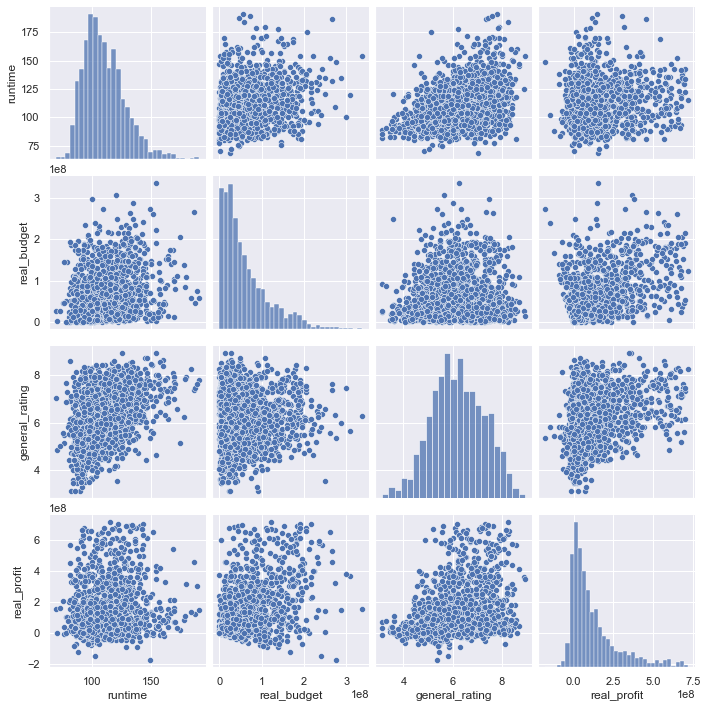

In [4]:
sb.pairplot(data = numericData)

                 runtime  real_budget  general_rating  real_profit
runtime         1.000000     0.286477        0.411824     0.175351
real_budget     0.286477     1.000000        0.015179     0.463825
general_rating  0.411824     0.015179        1.000000     0.267765
real_profit     0.175351     0.463825        0.267765     1.000000


<AxesSubplot:>

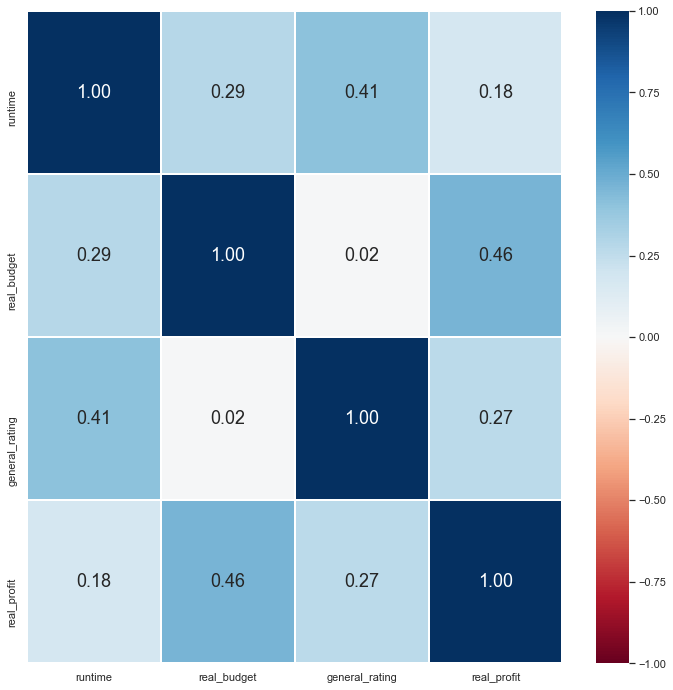

In [5]:
# Correlation Matrix
print(numericData.corr())

# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(12, 12))
sb.heatmap(numericData.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

In [6]:
import altair

In [7]:
from vega_datasets import data

In [8]:
# data = exploringData

# brush = alt.selection_interval()

# points = alt.Chart(data).mark_point().encode(
#     x='real_budget:Q',
#     y='real_profit:Q',
#     color=alt.condition(brush, 'Rated:N', alt.value('lightgray'))
# ).add_selection(
#     brush
# )
# bars = alt.Chart(data).mark_bar().encode(
#     y='Year:N',
#     color='Year:N',
#     x='count(Year):Q'
# ).transform_filter(
#     brush
# )
# points & bars

---
## BUDGET

Correlation between budget and profit:  0.463825


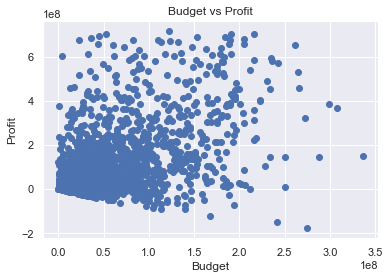

In [9]:
plt.scatter(x = exploringData["real_budget"], y = exploringData["real_profit"])
plt.title("Budget vs Profit")
plt.xlabel("Budget")
plt.ylabel("Profit")
print("Correlation between budget and profit:  0.463825")

Correlation between budget and general rating: 0.015179


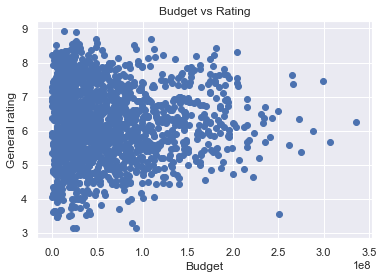

In [10]:
plt.scatter(x = exploringData["real_budget"], y =  exploringData["general_rating"],)
plt.title("Budget vs Rating")
plt.xlabel("Budget")
plt.ylabel("General rating")
print("Correlation between budget and general rating: 0.015179")

**Comments on Budget v Real Profits**

The correlation value and scatter plot above indicates that there is a moderate positive correlation between budget and real profits. 

The best-fit line plotted below shows that an increase in Budget will lead to an increase in Profit. Since we are able to derive a relative relationship between budget and profit, we can conclude that Budget could be a indicator in predicting the real profits of the movie.

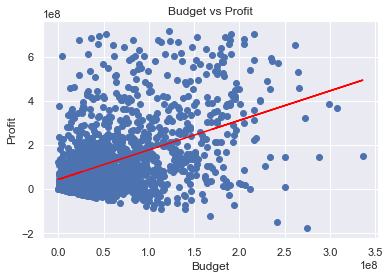

In [11]:
plt.scatter(x = exploringData["real_budget"], y = exploringData["real_profit"])
plt.title("Budget vs Profit")
plt.xlabel("Budget")
plt.ylabel("Profit")

x = exploringData["real_budget"]
y = exploringData["real_profit"]
m, b = np.polyfit(x, y, 1)
plt.plot(x,m*x+b, color = "red")

**Comments on Budget v General Ratings**

As seen from the correlation value and the scatter plot above, we can tell that there is a very weak positive correlation between budget and general ratings.

Since there is almost no relationship between budget and general ratings, Budget will not be a good indicator in helping us predict the General Ratings of a movie. 

---
## RUN-TIME

Correlation between run-time and profit: 0.175351


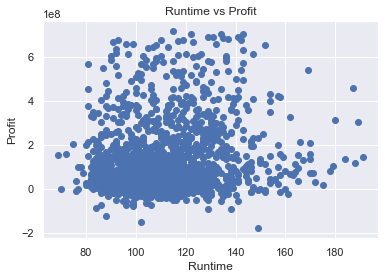

In [12]:
plt.scatter(x = exploringData["runtime"], y = exploringData["real_profit"])
plt.title("Runtime vs Profit")
plt.xlabel("Runtime")
plt.ylabel("Profit")
print("Correlation between run-time and profit: 0.175351")

Correlation between run-time and general rating: 0.411824


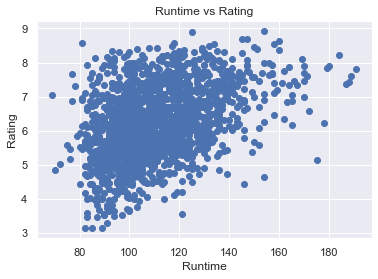

In [13]:
plt.scatter(x = exploringData["runtime"], y = exploringData["general_rating"])
plt.title("Runtime vs Rating")
plt.xlabel("Runtime")
plt.ylabel("Rating")
print("Correlation between run-time and general rating: 0.411824")

**Comments on Runtime v Real Profits**

Considering the correlation value as well as the how the points are distributed on the scatterplot, we can tell that there is a poor correlation between runtime and real profits. 
Hence, we can conclude that runtime would not be a good indicator in predicting real profits of the movie. 

**Comments on Runtime v General Rating**

The correlation value and scatter plot above indicates that there is a moderate positive correlation between runtime and general ratings. 

The best-fit line plotted below shows that an increase in Runtime will lead to an increase in Profit. Since we are able to derive a relative relationship between runtime and general ratings, we can conclude that Runtime could be a indicator in predicting the general ratings of the movie.

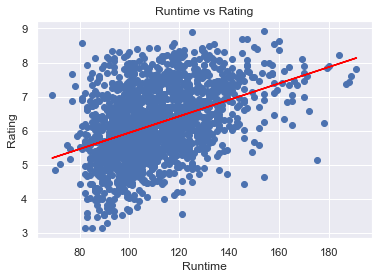

In [14]:
plt.scatter(x = exploringData["runtime"], y = exploringData["general_rating"])
plt.title("Runtime vs Rating")
plt.xlabel("Runtime")
plt.ylabel("Rating")

x = exploringData["runtime"]
y = exploringData["general_rating"]
m, b = np.polyfit(x, y, 1)
plt.plot(x,m*x+b, color = "red")

---
## Release Year and Release Month

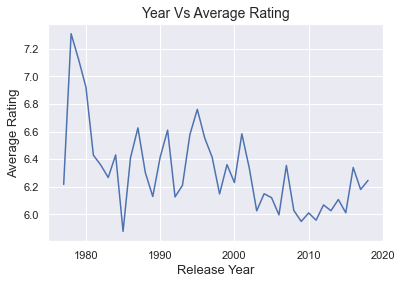

In [15]:
exploringData.groupby('Year')['general_rating'].mean().plot()

#setup the title and labels of the figure.
plt.title("Year Vs Average Rating",fontsize = 14)
plt.xlabel('Release Year',fontsize = 13)
plt.ylabel('Average Rating',fontsize = 13)

#setup the figure size.
sb.set(rc={'figure.figsize':(10,8)})
sb.set_style("whitegrid")

<AxesSubplot:xlabel='general_rating', ylabel='Year'>

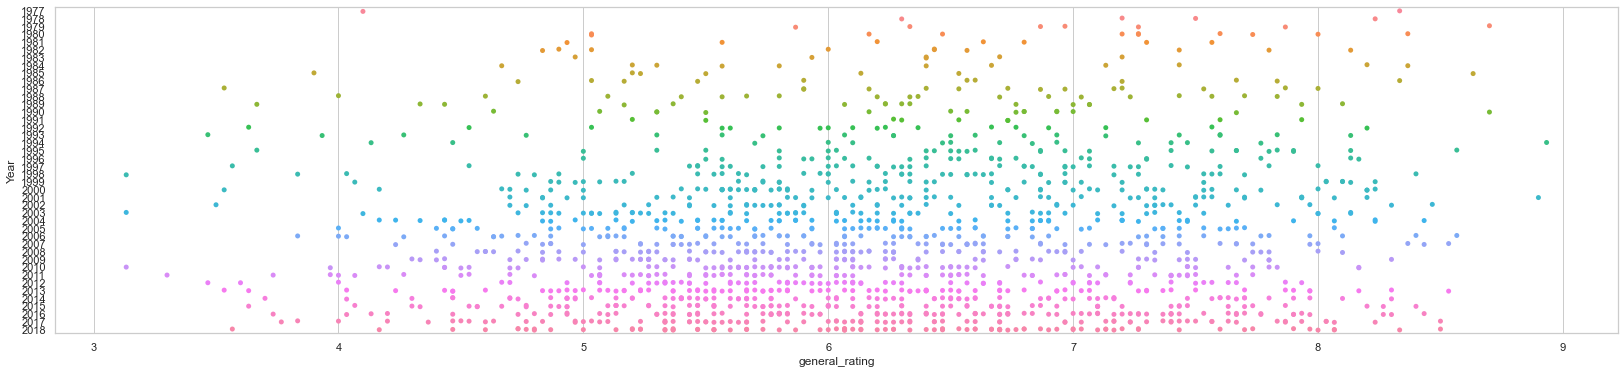

In [16]:
f = plt.figure(figsize=(28, 6))
sb.stripplot(x ="general_rating", y = "Year", data = exploringData, orient = "h")

Seems like average rating is going down!

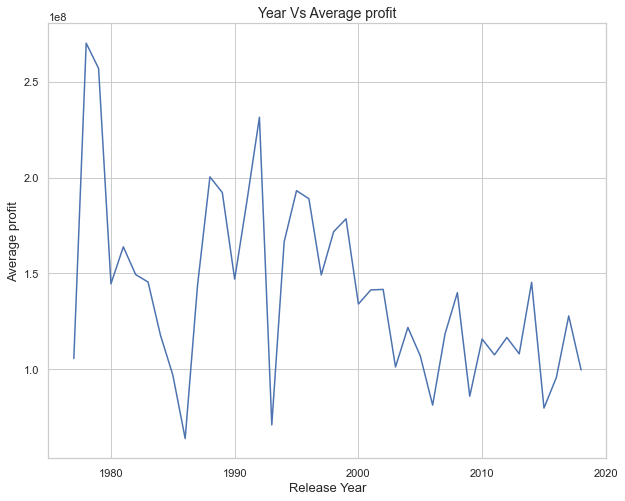

In [17]:
exploringData.groupby('Year')['real_profit'].mean().plot()

#setup the title and labels of the figure.
plt.title("Year Vs Average profit",fontsize = 14)
plt.xlabel('Release Year',fontsize = 13)
plt.ylabel('Average profit',fontsize = 13)

#setup the figure size.
sb.set(rc={'figure.figsize':(10,8)})
sb.set_style("whitegrid")

<AxesSubplot:xlabel='real_profit', ylabel='Year'>

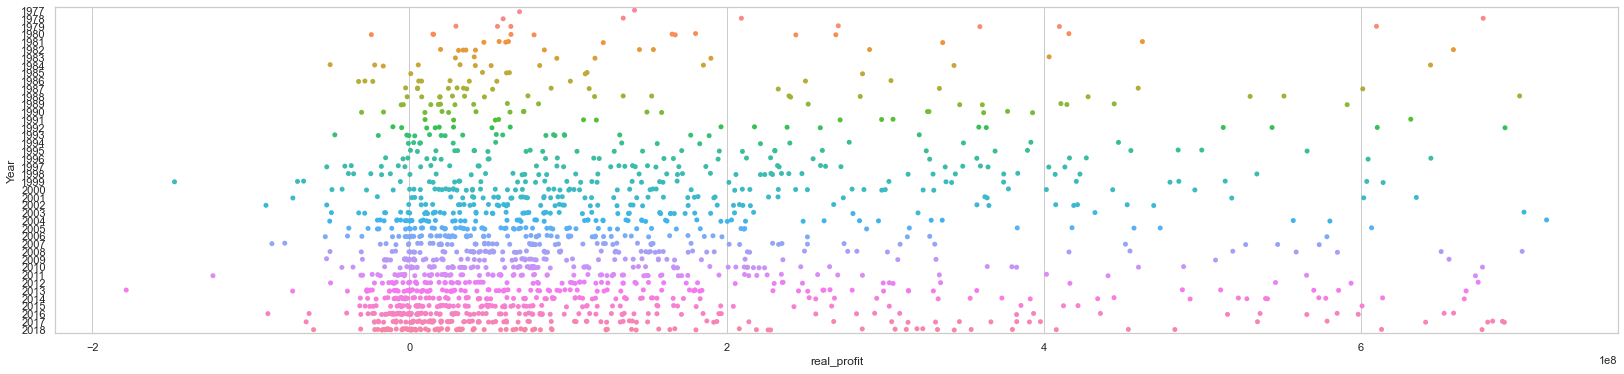

In [18]:
f = plt.figure(figsize=(28, 6))
sb.stripplot(x ="real_profit", y = "Year", data = exploringData, orient = "h")

Not much correlation between year and ratings / profits, how about month of release?

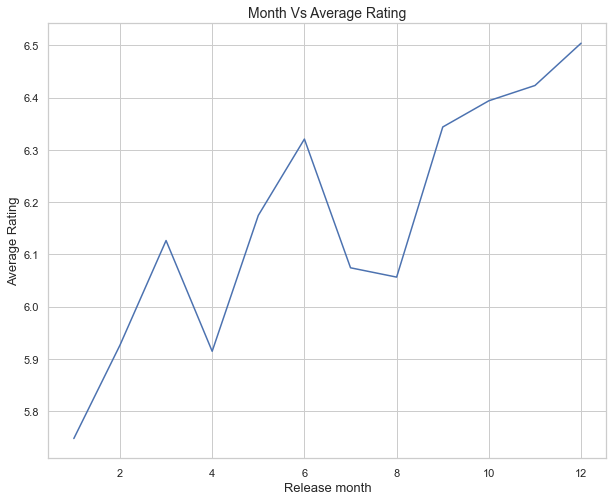

In [19]:
monthlist=[]
for i in range(len(exploringData["release_date"])):
    string= exploringData["release_date"][i]
    month =int(string[5:7])
    monthlist.append(month)
    
exploringData["month of release"] = pd.DataFrame(monthlist)


exploringData.groupby('month of release')['general_rating'].mean().plot()

#setup the title and labels of the figure.
plt.title("Month Vs Average Rating",fontsize = 14)
plt.xlabel('Release month',fontsize = 13)
plt.ylabel('Average Rating',fontsize = 13)

#setup the figure size.
sb.set(rc={'figure.figsize':(10,8)})
sb.set_style("whitegrid")

<AxesSubplot:xlabel='general_rating', ylabel='month of release'>

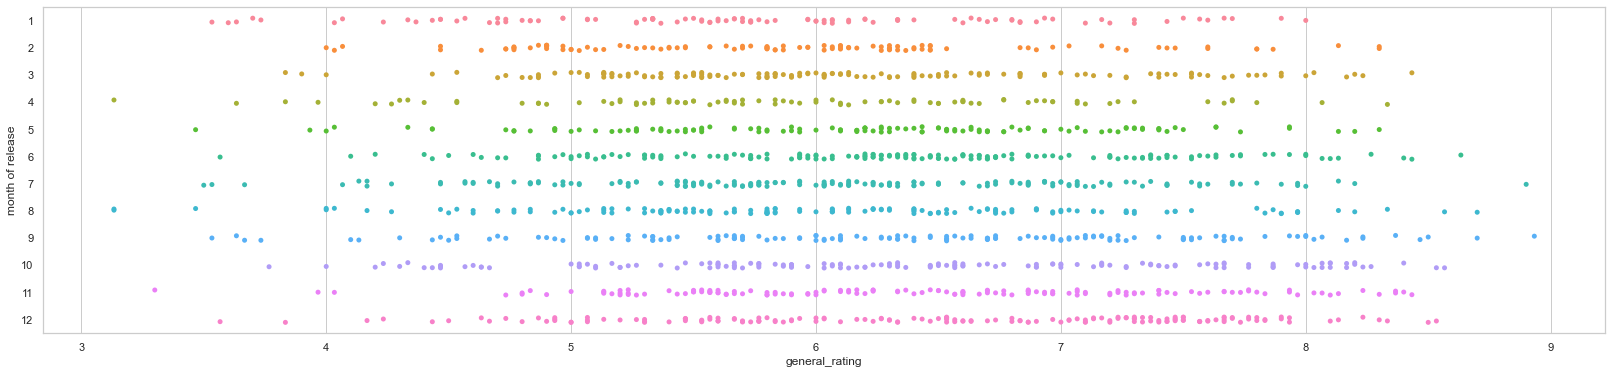

In [20]:
f = plt.figure(figsize=(28, 6))
sb.stripplot(x ="general_rating", y = "month of release", data = exploringData, orient = "h")

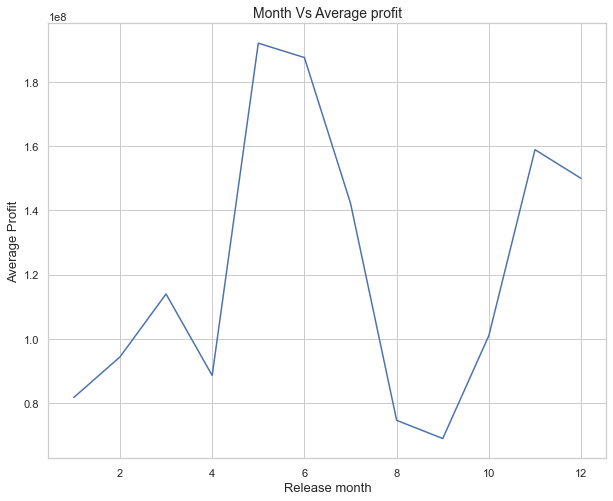

In [21]:
exploringData.groupby('month of release')['real_profit'].mean().plot()

#setup the title and labels of the figure.
plt.title("Month Vs Average profit",fontsize = 14)
plt.xlabel('Release month',fontsize = 13)
plt.ylabel('Average Profit',fontsize = 13)

#setup the figure size.
sb.set(rc={'figure.figsize':(10,8)})
sb.set_style("whitegrid")

<AxesSubplot:xlabel='real_profit', ylabel='month of release'>

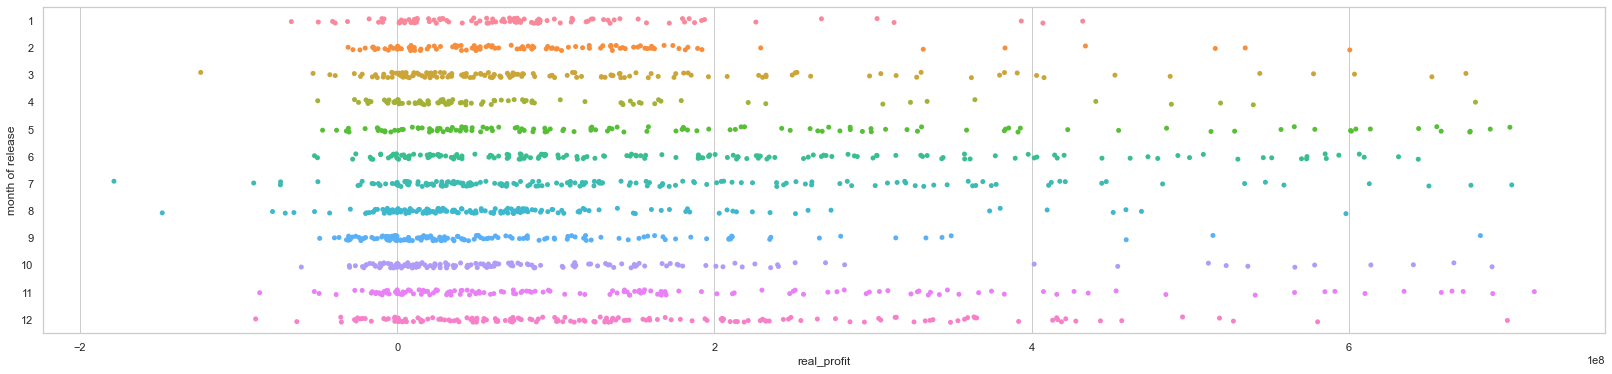

In [22]:
f = plt.figure(figsize=(28, 6))
sb.stripplot(x ="real_profit", y = "month of release", data = exploringData, orient = "h")

---
## Genre

In [23]:
genre_list = []
for i in range(len(exploringData["Genre"])):
    genre_list.append(exploringData["Genre"][i].split(", "))
    
diff_genre_types= set()
for i in range(len(genre_list)):
    for j in range(len(genre_list[i])):
         diff_genre_types.add(genre_list[i][j])
            
genre_list = list(diff_genre_types)

print(genre_list)

['Sci-Fi', 'Musical', 'Romance', 'Crime', 'Family', 'War', 'Mystery', 'Western', 'Sport', 'Biography', 'Music', 'Animation', 'Thriller', 'Adventure', 'Horror', 'Fantasy', 'Comedy', 'Action', 'History', 'Documentary', 'Drama']


In [24]:
genre_data = exploringData.copy()

for i in diff_genre_types:
    genre_data[i] = False

for i in range(len(genre_data)):
    for j in genre_list:
        if j in genre_data["Genre"][i].split(", "):
            genre_data[j][i] = 1

<ipython-input-24-55842689aa29>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_data[j][i] = 1


In [25]:
genre_data

,original_language,release_date,runtime,title,Genre,Year,Ratings,Rated,general_rating,real_budget,...,Animation,Thriller,Adventure,Horror,Fantasy,Comedy,Action,History,Documentary,Drama
0,en,2014-05-14,123.0,Godzilla,"Action, Adventure, Sci-Fi, Thriller",2014,"[{None: None}, {None: None}, {None: None}]",PG-13,6.266667,1.697128e+08,...,False,True,True,False,False,False,True,False,False,False
1,en,2017-03-08,118.0,Kong: Skull Island,"Action, Adventure, Fantasy, Sci-Fi",2017,"[{None: None}, {None: None}, {None: None}]",PG-13,6.433333,1.895186e+08,...,False,False,True,False,True,False,True,False,False,False
2,en,2018-08-09,113.0,The Meg,"Action, Horror, Sci-Fi, Thriller",2018,"[{None: None}, {None: None}, {None: None}]",PG-13,5.466667,1.500000e+08,...,False,True,False,True,False,False,True,False,False,False
3,en,2016-10-07,139.0,Hacksaw Ridge,"Biography, Drama, History, War",2016,"[{None: None}, {None: None}, {None: None}]",R,7.766667,4.184995e+07,...,False,False,False,False,False,False,False,True,False,True
4,en,2018-09-05,107.0,The Predator,"Action, Adventure, Sci-Fi",2018,"[{'Source': 'Internet Movie Database', 'Value'...",R,5.233333,8.800000e+07,...,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,en,1987-06-30,120.0,Innerspace,"Action, Adventure, Comedy, Sci-Fi, Thriller",1987,"[{'Source': 'Internet Movie Database', 'Value'...",PG,6.733333,5.968212e+07,...,False,True,True,False,False,True,True,False,False,False
1644,en,2006-04-28,92.0,Another Gay Movie,"Comedy, Romance",2006,"[{'Source': 'Internet Movie Database', 'Value'...",Not Rated,4.800000,6.227852e+05,...,False,False,False,False,False,True,False,False,False,False
1645,en,1998-09-11,121.0,Rounders,"Crime, Drama",1998,"[{'Source': 'Internet Movie Database', 'Value'...",R,6.566667,1.848640e+07,...,False,False,False,False,False,False,False,False,False,True
1646,en,1983-06-17,125.0,Superman III,"Action, Adventure, Comedy, Sci-Fi",1983,"[{'Source': 'Internet Movie Database', 'Value'...",PG,4.966667,9.832503e+07,...,False,False,True,False,False,True,True,False,False,False


In [26]:
genre_list2 = [genre_data[i].value_counts()[1] for i in genre_list]
print(sorted([(x,genre_list[i]) for (i,x) in enumerate(genre_list2)], reverse=True )[:3] )
print(sorted([(x,genre_list[i]) for (i,x) in enumerate(genre_list2)])[:3] )



[(700, 'Drama'), (641, 'Thriller'), (610, 'Action')]
[(4, 'Documentary'), (24, 'Western'), (36, 'Musical')]


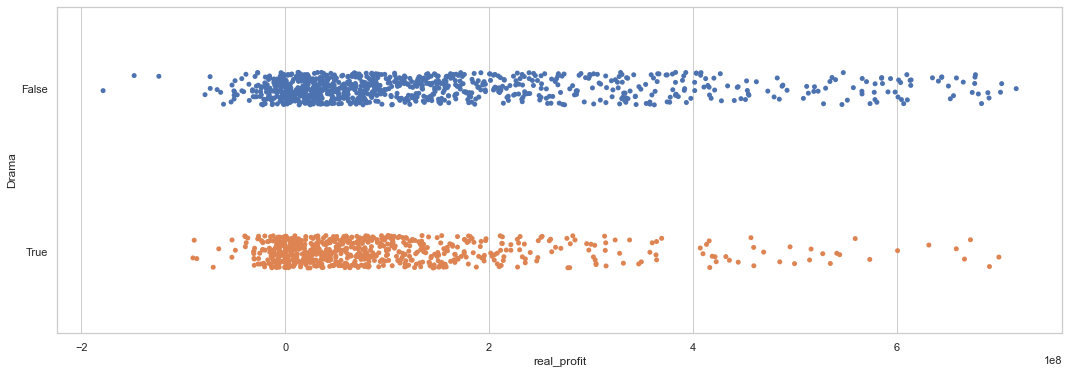

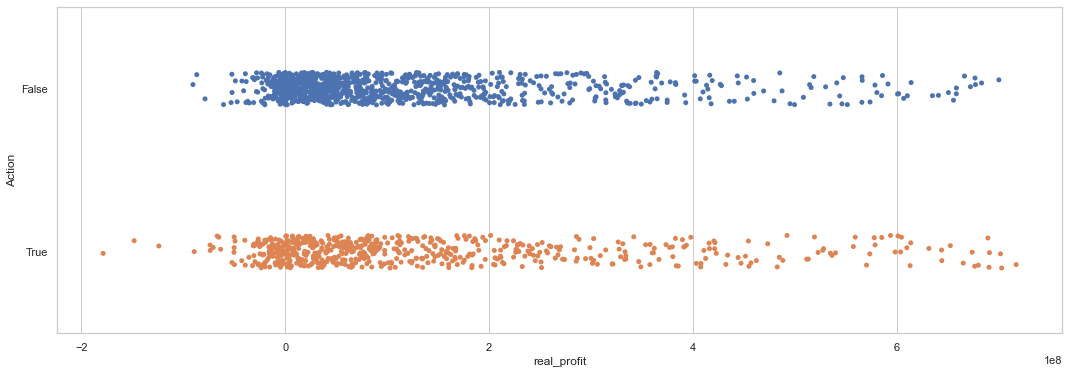

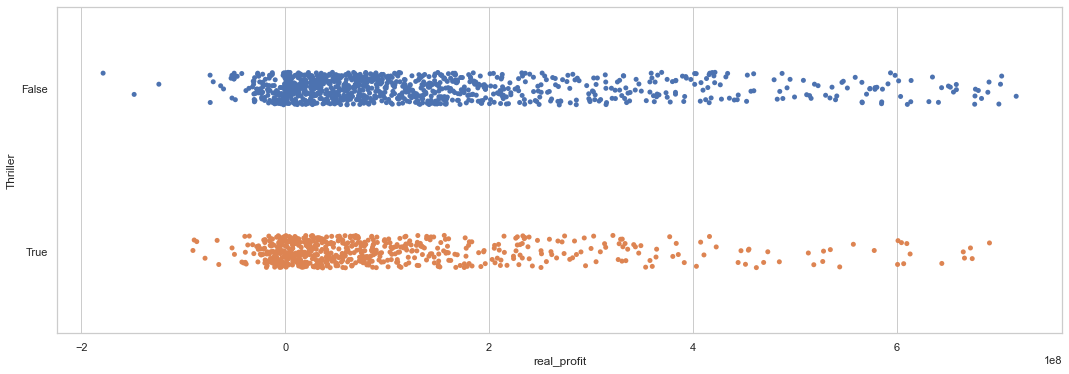

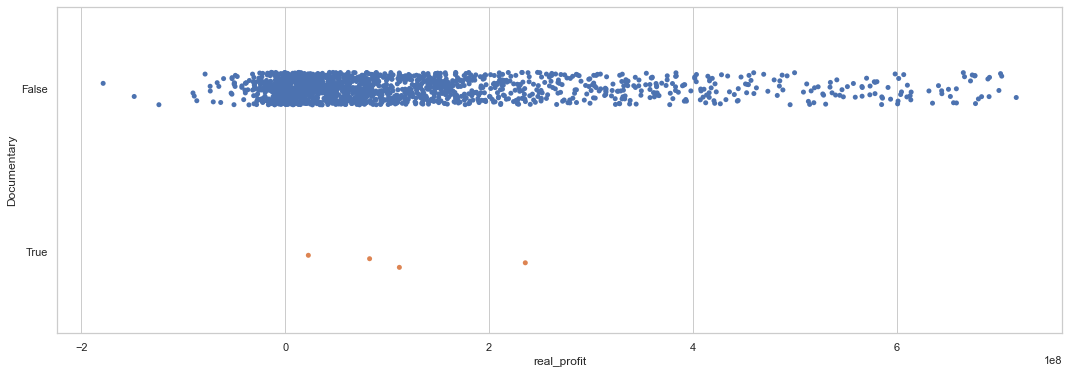

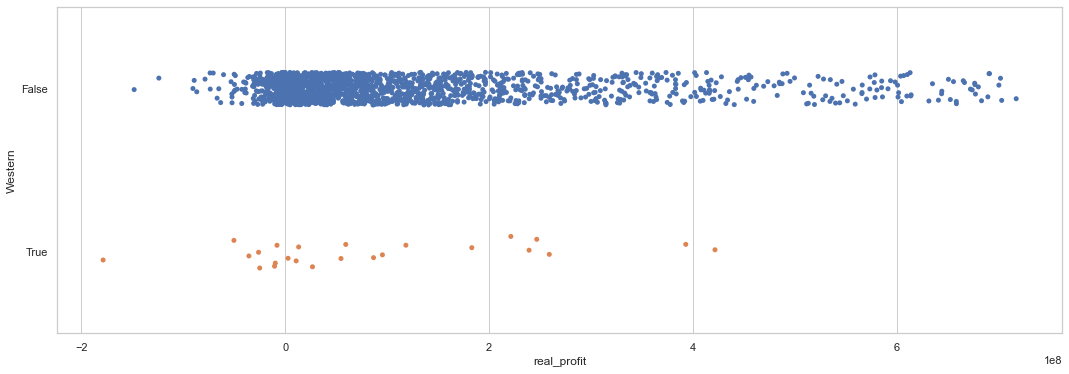

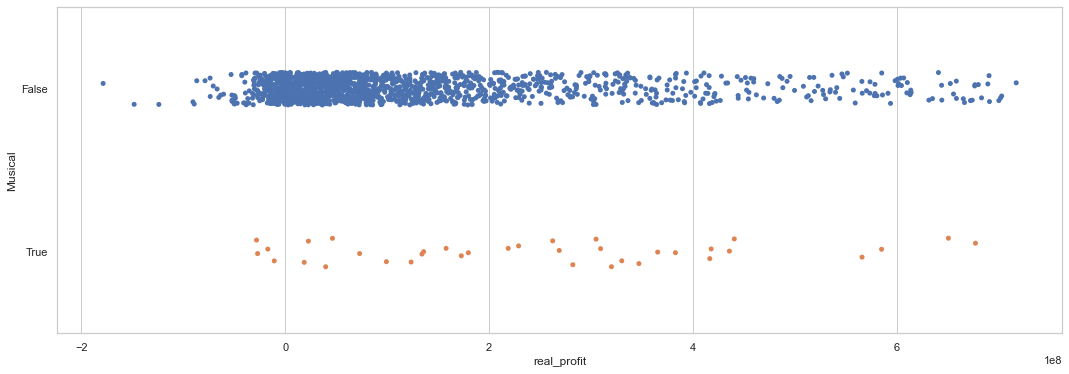

In [27]:
most_popular_genres = ["Drama", "Action", "Thriller"]
most_unpopular_genres = ["Documentary",'Western','Musical'  ]
for i in most_popular_genres:
    f = plt.figure(figsize=(18, 6))
    sb.stripplot(x ="real_profit", y = i, data = genre_data, orient = "h")

for i in most_unpopular_genres:
    f = plt.figure(figsize=(18, 6))
    sb.stripplot(x ="real_profit", y = i, data = genre_data, orient = "h")

**Comments on Genre v Real Profits**

From the above stripplots, we can see that there is no substatial separation of profits between when a given genre is **True**, indicating that a movie is of that particular genre, and when it is **False**.

Based on that, it seems that the genre of a movie alone does not serve as a good indicator of what the real profits of the movie would be.

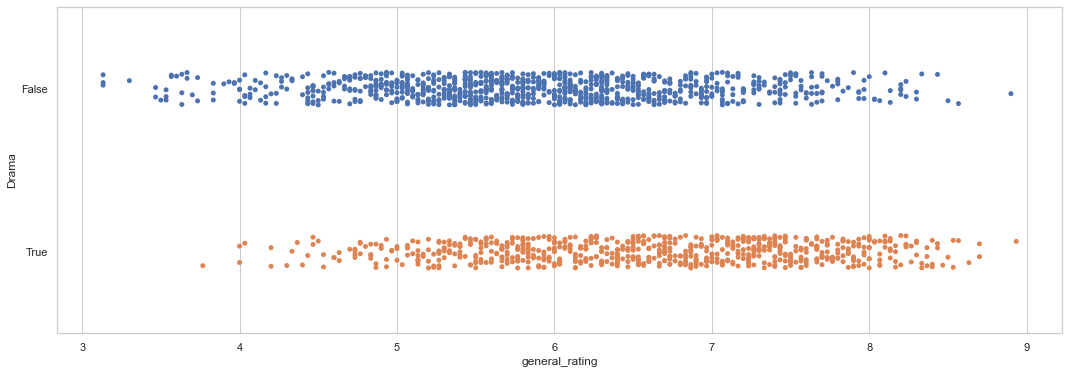

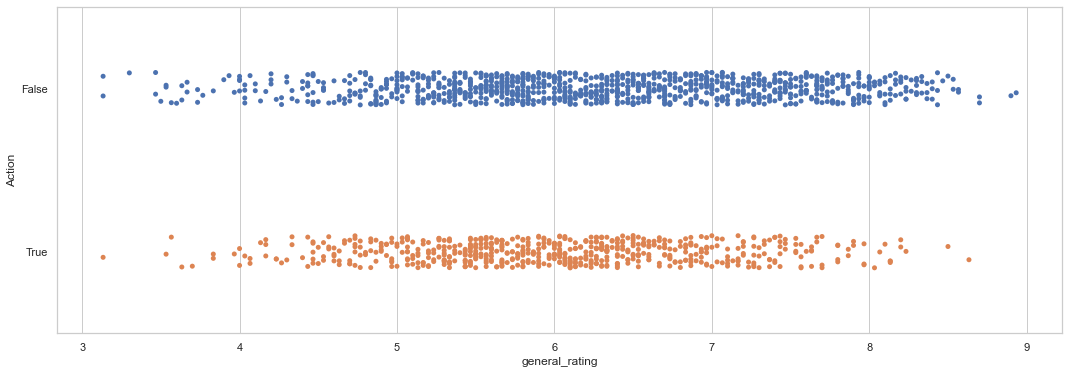

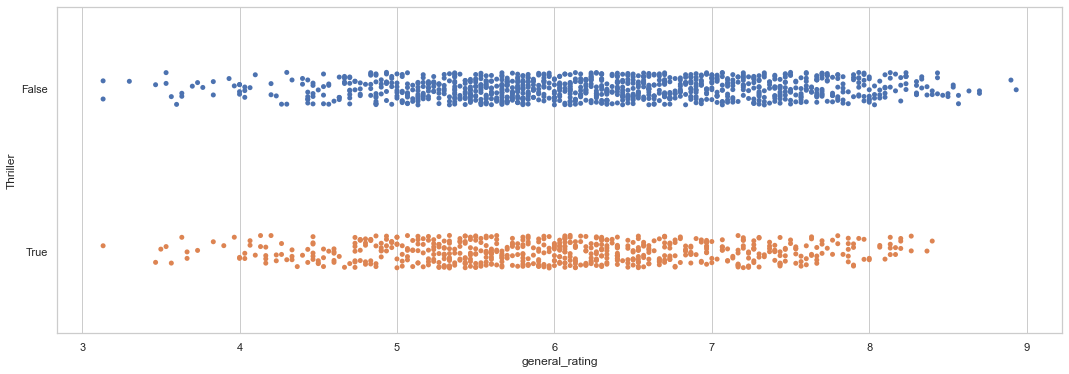

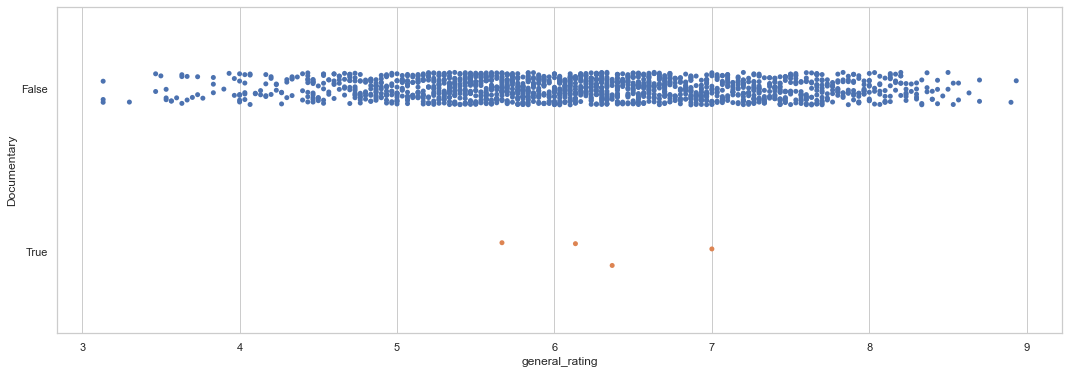

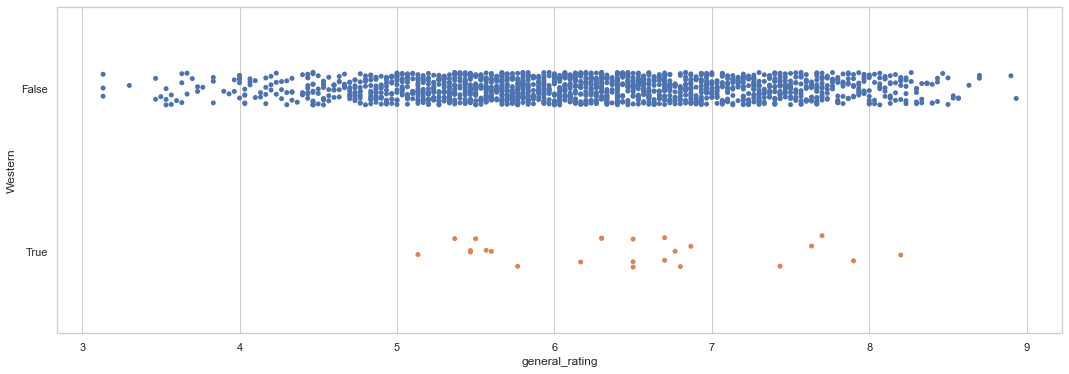

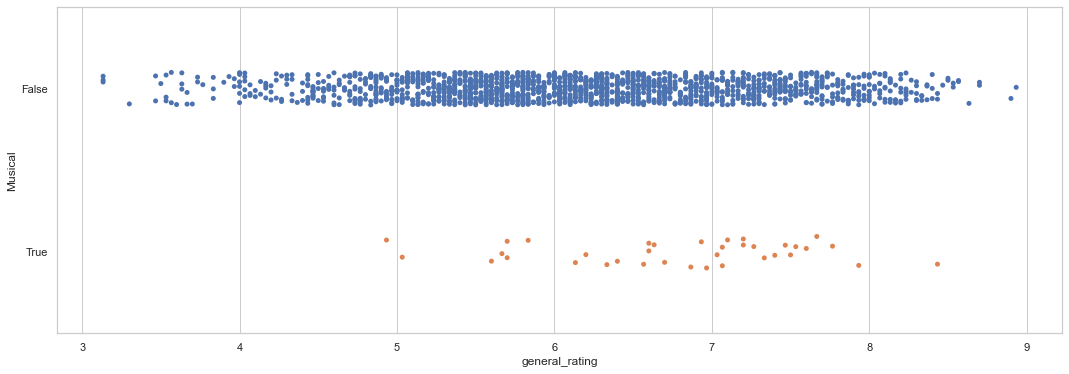

In [28]:
for i in most_popular_genres:
    f = plt.figure(figsize=(18, 6))
    sb.stripplot(x ="general_rating", y = i, data = genre_data, orient = "h")

for i in most_unpopular_genres:
    f = plt.figure(figsize=(18, 6))
    sb.stripplot(x ="general_rating", y = i, data = genre_data, orient = "h")

**Comments on Genre v General Rating**

Similar to ther results of Genre v Real Profits, there is no substantial separation of the ratings between when a given genre is **True**, as compared to movies with that are not of the same genre (**False**).

Based on that, it seems that the genre of a movie also do not serve as a good indicator of how well a movie will perform based on profits.

---
## Language

In [29]:
language_list = set()
for i in range(len(exploringData["original_language"])):
    language_list.add(exploringData["original_language"][i])
    
language_list = list(language_list)
            
print(language_list)

['zh', 'cn', 'en', 'id', 'pt', 'ja', 'ko', 'no', 'es', 'el', 'th', 'nb', 'ar', 'fr', 'da', 'hi']


In [30]:
exploringData.groupby(by="original_language").agg("count")

,release_date,runtime,title,Genre,Year,Ratings,Rated,general_rating,real_budget,real_profit,month of release
original_language,,,,,,,,,,,
ar,1,1,1,1,1,1,1,1,1,1,1
cn,7,7,7,7,7,7,7,7,7,7,7
da,1,1,1,1,1,1,1,1,1,1,1
el,1,1,1,1,1,1,1,1,1,1,1
en,1590,1590,1590,1590,1590,1590,1590,1590,1590,1590,1590
es,8,8,8,8,8,8,8,8,8,8,8
fr,6,6,6,6,6,6,6,6,6,6,6
hi,2,2,2,2,2,2,2,2,2,2,2
id,2,2,2,2,2,2,2,2,2,2,2


With majority of the languages being english.........

**RATINGS (PG13.. NC16)**

In [31]:
exploringData.groupby(by="Rated").agg("count")

,original_language,release_date,runtime,title,Genre,Year,Ratings,general_rating,real_budget,real_profit,month of release
Rated,,,,,,,,,,,
G,42,42,42,42,42,42,42,42,42,42,42
NC-17,2,2,2,2,2,2,2,2,2,2,2
Not Rated,19,19,19,19,19,19,19,19,19,19,19
PG,263,263,263,263,263,263,263,263,263,263,263
PG-13,578,578,578,578,578,578,578,578,578,578,578
R,738,738,738,738,738,738,738,738,738,738,738
TV-MA,3,3,3,3,3,3,3,3,3,3,3
Unrated,3,3,3,3,3,3,3,3,3,3,3


# Machine Learning

**DECIDED VARIABLES**

1) Response Variable: **Real Profits**

   Predictor: **Budget**


In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

budget = pd.DataFrame(exploringData['real_budget']) #Predictor 
profit = pd.DataFrame(exploringData['real_profit']) #Response

# Split the Dataset into Train and Test
budget_train, budget_test, profit_train, profit_test = train_test_split(budget, profit, test_size = 200, train_size = 600)

**Linear Regression Model**

In [33]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression

# Create a Linear Regression object
linreg = LinearRegression()

# Train the Linear Regression model //
linreg.fit(budget_train, profit_train)

print('Intercept \t: b = ', linreg.intercept_)
print('Coefficients \t: a = ', linreg.coef_)

# Formula for the Regression line
regline_x = budget_train
regline_y = linreg.intercept_ + linreg.coef_ * budget_train
# Predict Total values corresponding to HP Train
profit_train_pred = linreg.predict(budget_train)

Intercept 	: b =  [47839413.83322099]
Coefficients 	: a =  [[1.29427275]]


Train the model linreg using train set.

Explained Variance (R^2) 	: 0.19305807105376627
Mean Squared Error (MSE) 	: 2.2507988521632756e+16
Root Mean Squared Error (RMSE) 	: 150026626.04228875

How good the predictions are on Test Set:

Explained Variance (R^2) 	: 0.2170085316532553
Mean Squared Error (MSE) 	: 1.4801461214520454e+16
Root Mean Squared Error (RMSE) 	: 121661256.0124235


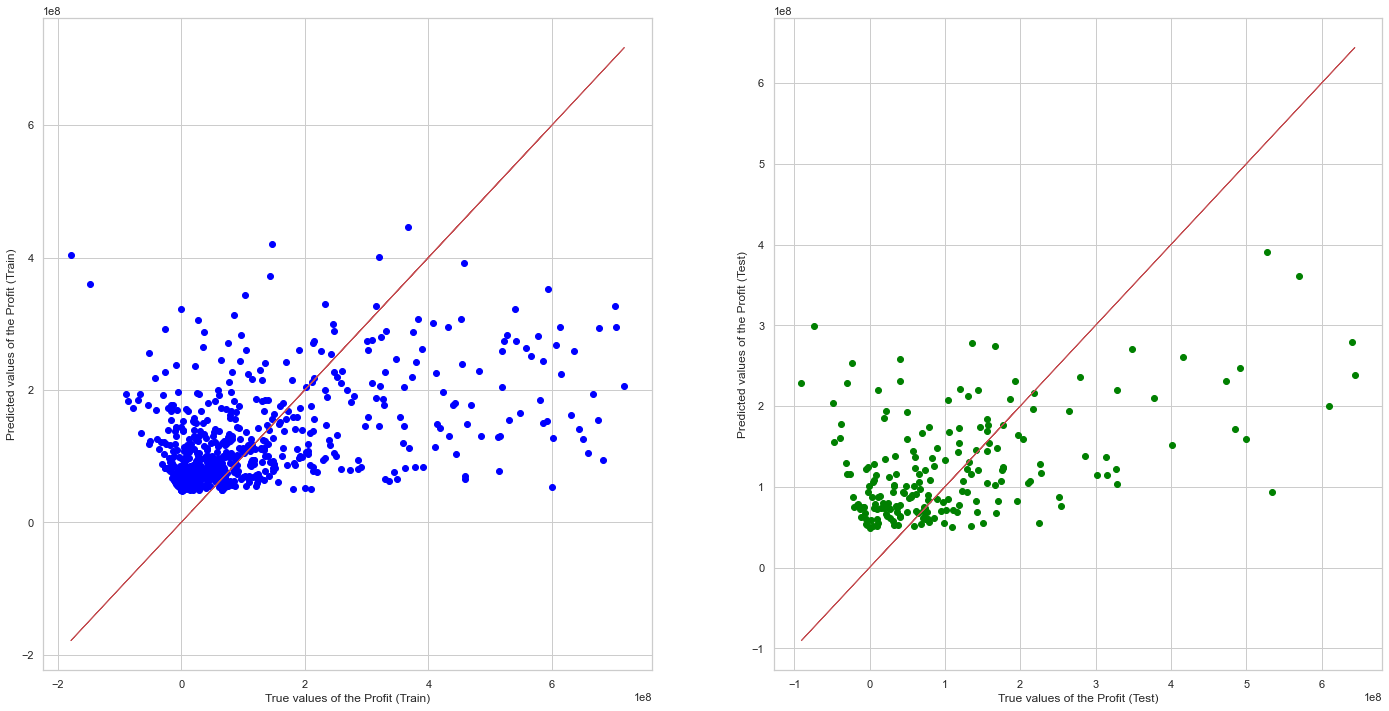

In [34]:
# Explained Variance (R^2)
print("Explained Variance (R^2) \t:", linreg.score(budget_train, profit_train))

# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))


mse = mean_sq_err(profit_train, profit_train_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

profit_test_pred = linreg.predict(budget_test)

print("\nHow good the predictions are on Test Set:\n")
# Explained Variance (R^2)
print("Explained Variance (R^2) \t:", linreg.score(budget_test, profit_test))

# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))

mse = mean_sq_err(profit_test, profit_test_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(profit_train, profit_train_pred, color = "blue")
axes[0].plot(profit_train, profit_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Profit (Train)")
axes[0].set_ylabel("Predicted values of the Profit (Train)")
axes[1].scatter(profit_test, profit_test_pred, color = "green")
axes[1].plot(profit_test, profit_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Profit (Test)")
axes[1].set_ylabel("Predicted values of the Profit (Test)")
plt.show()

**DECIDED VARIABLES**

2) Response Variable: **General Rating**

   Predictor: **Budget**


In [35]:
budget = pd.DataFrame(exploringData['real_budget']) #Predictor 
rating = pd.DataFrame(exploringData['general_rating']) #Response

# Split the Dataset into Train and Test
budget_train, budget_test, rating_train, rating_test = train_test_split(budget, rating, test_size = 200, train_size = 600)

**Linear Regression Model**


In [36]:
# Create a Linear Regression object
linreg = LinearRegression()

# Train the Linear Regression model //
linreg.fit(budget_train, rating_train)

print('Intercept \t: b = ', linreg.intercept_)
print('Coefficients \t: a = ', linreg.coef_)

# Formula for the Regression line
regline_x = budget_train
regline_y = linreg.intercept_ + linreg.coef_ * budget_train
# Predict Total values corresponding to HP Train
rating_train_pred = linreg.predict(budget_train)

Intercept 	: b =  [6.21040573]
Coefficients 	: a =  [[2.35614576e-10]]


Train the model linreg using train set.

Explained Variance (R^2) 	: 0.0001361370189695288
Mean Squared Error (MSE) 	: 1.1221880844020096
Root Mean Squared Error (RMSE) 	: 1.0593337927216377

How good the predictions are on Test Set:

Explained Variance (R^2) 	: -0.014878348757982662
Mean Squared Error (MSE) 	: 1.4801461214520454e+16
Root Mean Squared Error (RMSE) 	: 121661256.0124235


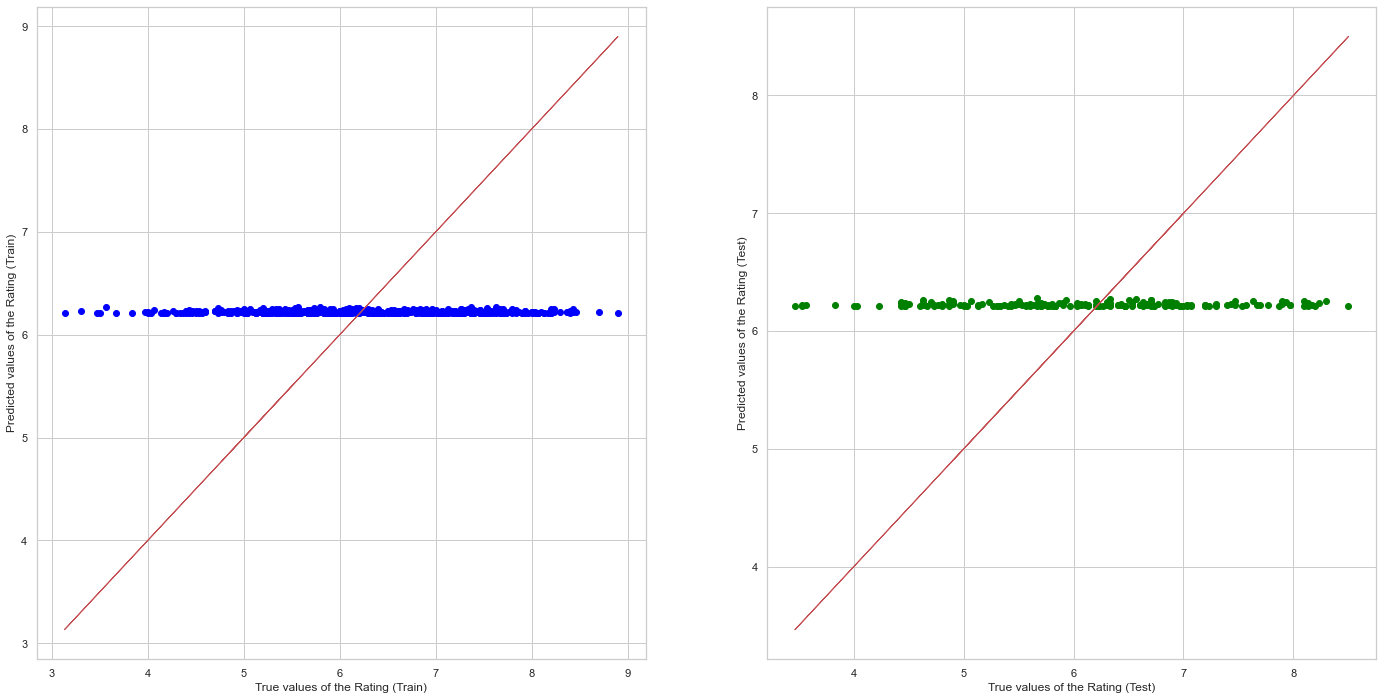

In [37]:
# Explained Variance (R^2)
print("Explained Variance (R^2) \t:", linreg.score(budget_train, rating_train))

# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))


mse = mean_sq_err(rating_train, rating_train_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

rating_test_pred = linreg.predict(budget_test)

print("\nHow good the predictions are on Test Set:\n")
# Explained Variance (R^2)
print("Explained Variance (R^2) \t:", linreg.score(budget_test, rating_test))

# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))

mse = mean_sq_err(profit_test, profit_test_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(rating_train, rating_train_pred, color = "blue")
axes[0].plot(rating_train, rating_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Rating (Train)")
axes[0].set_ylabel("Predicted values of the Rating (Train)")
axes[1].scatter(rating_test, rating_test_pred, color = "green")
axes[1].plot(rating_test, rating_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Rating (Test)")
axes[1].set_ylabel("Predicted values of the P (Test)")
plt.show()

3) Response Variable: **Profit**

   Predictor: **Runtime**

In [38]:
runtime = pd.DataFrame(exploringData['runtime']) #Predictor 
profit = pd.DataFrame(exploringData['real_profit']) #Response

# Split the Dataset into Train and Test
runtime_train, runtime_test, profit_train, profit_test = train_test_split(runtime, profit, test_size = 200, train_size = 600)

**Linear Regression Model**

In [39]:
# Create a Linear Regression object
linreg = LinearRegression()

# Train the Linear Regression model //
linreg.fit(runtime_train, profit_train)

print('Intercept \t: b = ', linreg.intercept_)
print('Coefficients \t: a = ', linreg.coef_)

# Formula for the Regression line
regline_x = runtime_train
regline_y = linreg.intercept_ + linreg.coef_ * runtime_train
# Predict Total values corresponding to HP Train
profit_train_pred = linreg.predict(runtime_train)

Intercept 	: b =  [-33326942.13641094]
Coefficients 	: a =  [[1407269.40864356]]


Train the model linreg using train set.

Explained Variance (R^2) 	: 0.02801181796463148
Mean Squared Error (MSE) 	: 2.412806330733428e+16
Root Mean Squared Error (RMSE) 	: 155332106.49229696

How good the predictions are on Test Set:

Explained Variance (R^2) 	: 0.021248724182510115
Mean Squared Error (MSE) 	: 1.1675435386997952
Root Mean Squared Error (RMSE) 	: 1.080529286368396


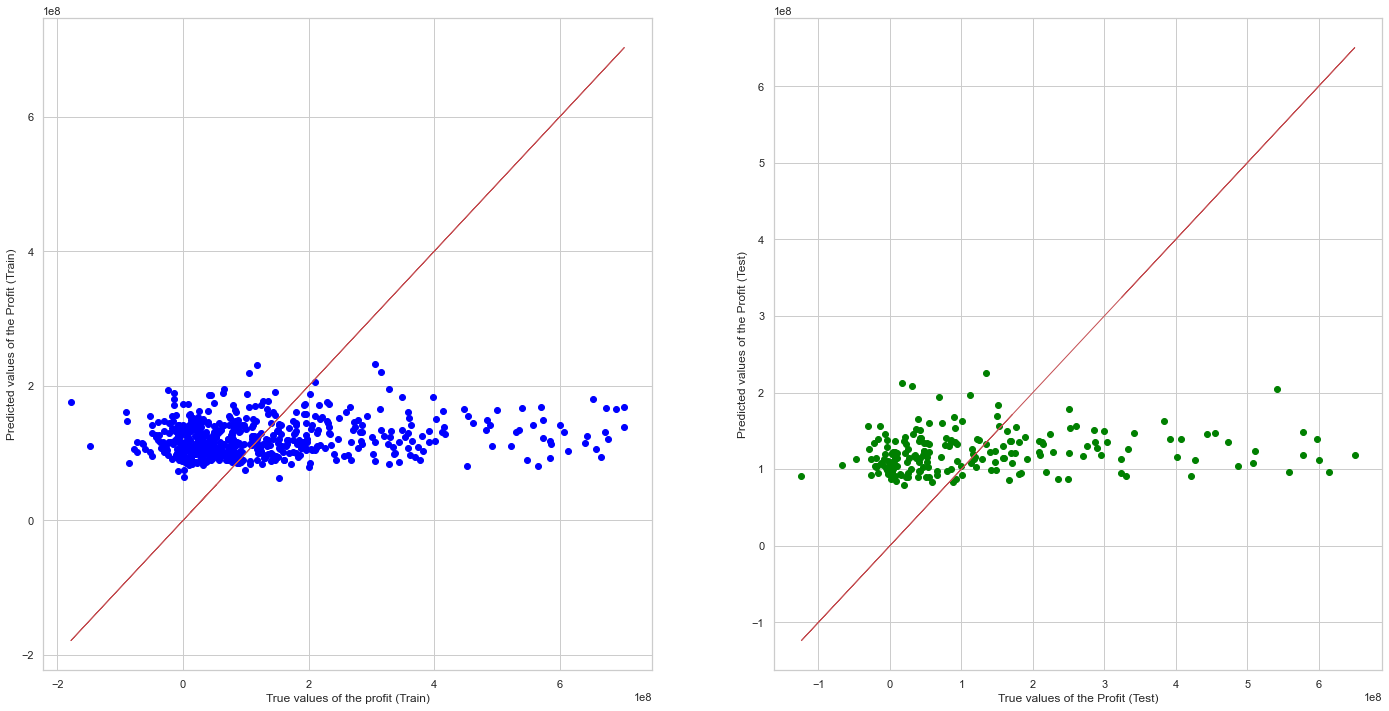

In [40]:
# Explained Variance (R^2)
print("Explained Variance (R^2) \t:", linreg.score(runtime_train, profit_train))

# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))


mse = mean_sq_err(profit_train, profit_train_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

profit_test_pred = linreg.predict(runtime_test)

print("\nHow good the predictions are on Test Set:\n")
# Explained Variance (R^2)
print("Explained Variance (R^2) \t:", linreg.score(runtime_test, profit_test))

# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))

mse = mean_sq_err(rating_test, rating_test_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(profit_train, profit_train_pred, color = "blue")
axes[0].plot(profit_train, profit_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the profit (Train)")
axes[0].set_ylabel("Predicted values of the Profit (Train)")
axes[1].scatter(profit_test, profit_test_pred, color = "green")
axes[1].plot(profit_test, profit_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Profit (Test)")
axes[1].set_ylabel("Predicted values of the Profit (Test)")
plt.show()

4) Response Variable: **General Ratings**

   Predictor: **Runtime**

In [41]:
runtime = pd.DataFrame(exploringData['runtime']) #Predictor 
rating = pd.DataFrame(exploringData['general_rating']) #Response

# Split the Dataset into Train and Test
runtime_train, runtime_test, rating_train, rating_test = train_test_split(runtime, rating, test_size = 200, train_size = 600)

**Linear Regression Model**

In [42]:
# Create a Linear Regression object
linreg = LinearRegression()

# Train the Linear Regression model //
linreg.fit(runtime_train, rating_train)

print('Intercept \t: b = ', linreg.intercept_)
print('Coefficients \t: a = ', linreg.coef_)

# Formula for the Regression line
regline_x = runtime_train
regline_y = linreg.intercept_ + linreg.coef_ * runtime_train
# Predict Total values corresponding to HP Train
rating_train_pred = linreg.predict(runtime_train)

Intercept 	: b =  [3.45421936]
Coefficients 	: a =  [[0.02453774]]


Train the model linreg using train set.

Explained Variance (R^2) 	: 0.1643828308792219
Mean Squared Error (MSE) 	: 0.9781238756416828
Root Mean Squared Error (RMSE) 	: 0.9890014538117134

How good the predictions are on Test Set:

Explained Variance (R^2) 	: 0.14999736665906405
Mean Squared Error (MSE) 	: 1.0121583676500983
Root Mean Squared Error (RMSE) 	: 1.0060608170732515


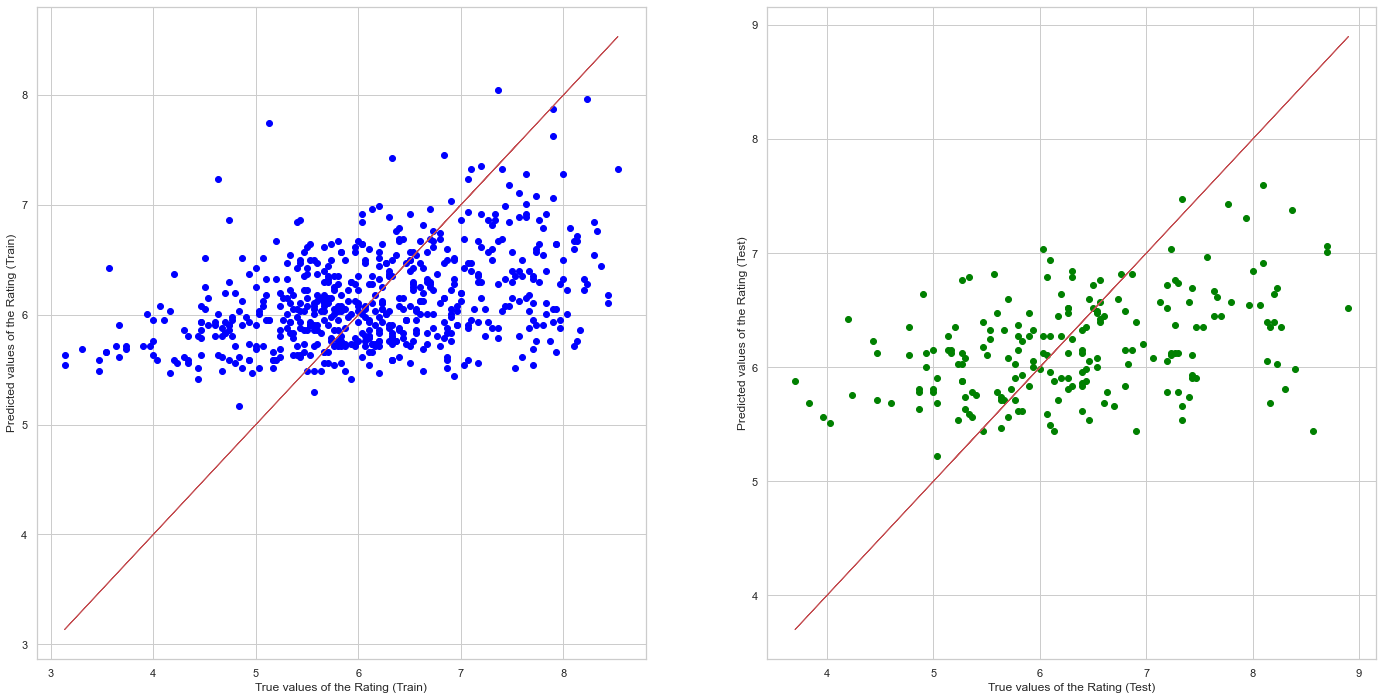

In [43]:
# Explained Variance (R^2)
print("Explained Variance (R^2) \t:", linreg.score(runtime_train, rating_train))

# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))


mse = mean_sq_err(rating_train, rating_train_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

rating_test_pred = linreg.predict(runtime_test)

print("\nHow good the predictions are on Test Set:\n")
# Explained Variance (R^2)
print("Explained Variance (R^2) \t:", linreg.score(runtime_test, rating_test))

# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))

mse = mean_sq_err(rating_test, rating_test_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(rating_train, rating_train_pred, color = "blue")
axes[0].plot(rating_train, rating_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Rating (Train)")
axes[0].set_ylabel("Predicted values of the Rating (Train)")
axes[1].scatter(rating_test, rating_test_pred, color = "green")
axes[1].plot(rating_test, rating_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Rating (Test)")
axes[1].set_ylabel("Predicted values of the Rating (Test)")
plt.show()

**Linear Regression Model**

---

## Multi-Variate Linear Regression

Let us set up a Multi-Variate Linear Regression problem.   

Response Variable : **Profits**     
Predictor Feature : **Runtime, Budget**       

> Regression Model : Profits = $a_1$ $\times$ Runtime + $a_2$ $\times$ Budget

In [64]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Extract Response and Predictors
y = pd.DataFrame(exploringData['real_profit'])
X = pd.DataFrame(exploringData[["runtime", "real_budget"]])

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

Intercept of Regression 	: b =  [3.19998926]
Coefficients of Regression 	: a =  [[ 2.86509800e-02 -2.43931328e-09]]



Intercept of Regression 	: b =  [15511392.53653891]
Coefficients of Regression 	: a =  [[3.37979926e+05 1.06735538e+00]]

    Predictors   Coefficients
0      runtime  337979.925557
1  real_budget       1.067355



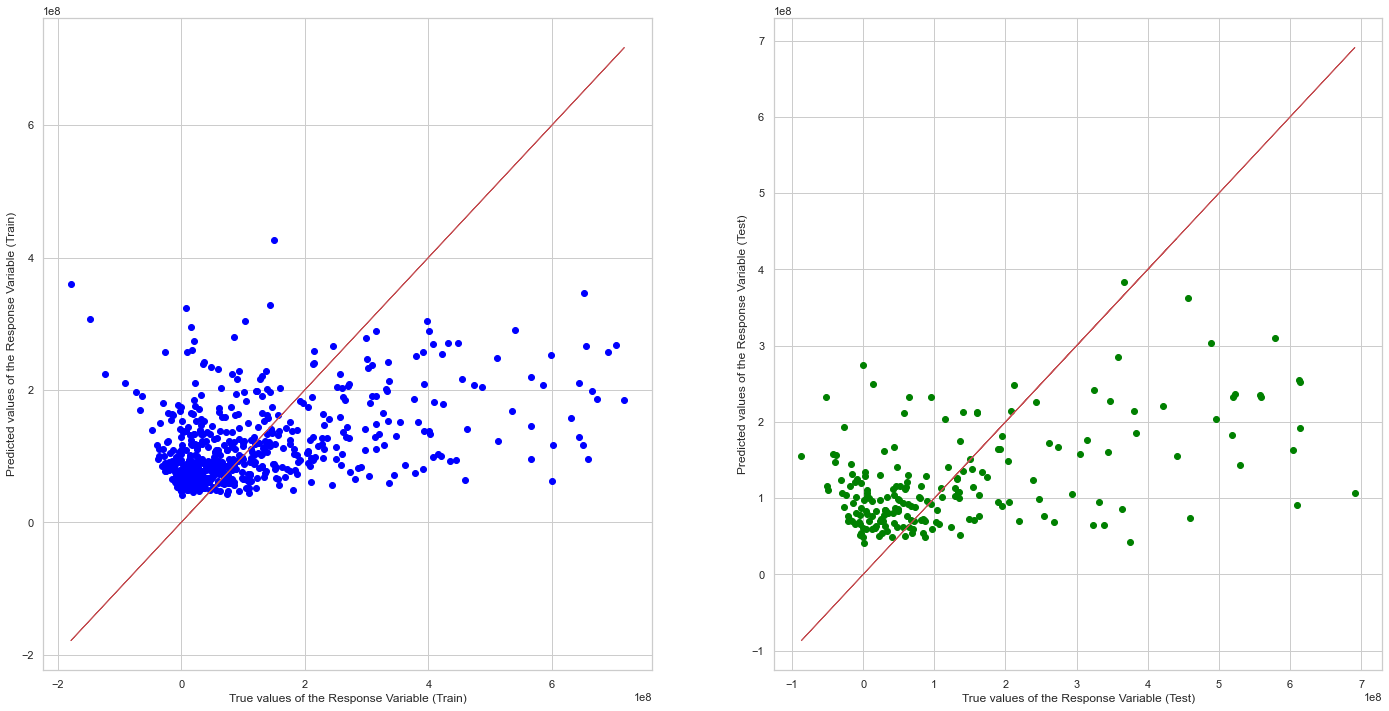

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.160587453961613
Mean Squared Error (MSE) 	: 1.956289058056875e+16

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.23927588452101967
Mean Squared Error (MSE) 	: 2.1568986421690828e+16



In [67]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 200, train_size = 600)

# Linear Regression using Train Data
linreg = LinearRegression()  # create the linear regression object
linreg.fit(X_train, y_train) # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

#### Prediction of Profits

Let's predict the value of **Profits** for a few specific movies -- *Solo: A Star Wars Story*, *Kingsman: The Golden Circle* and *Spirited Away* -- using the Regression Model derived above.   

In [53]:
# Extract Pokemons for Prediction
profit_pred = exploringData[exploringData["title"].isin(["Solo: A Star Wars Story", "Kingsman: The Golden Circle", "Spirited Away"])]
profit_pred

,original_language,release_date,runtime,title,Genre,Year,Ratings,Rated,general_rating,real_budget,real_profit,month of release
131,en,2018-05-15,135.0,Solo: A Star Wars Story,"Action, Adventure, Sci-Fi",2018,"[{'Source': 'Internet Movie Database', 'Value'...",PG-13,6.566667,2.500000e+08,1.429524e+08,5
137,en,2017-09-20,141.0,Kingsman: The Golden Circle,"Action, Adventure, Comedy, Crime, Thriller",2017,"[{'Source': 'Internet Movie Database', 'Value'...",R,6.033333,1.065402e+08,3.143987e+08,9
201,ja,2001-07-20,125.0,Spirited Away,"Animation, Adventure, Family, Fantasy, Mystery",2001,"[{'Source': 'Internet Movie Database', 'Value'...",PG,8.900000,2.693977e+07,3.628717e+08,7


In [54]:
predictors = ["runtime", "real_budget"]
# Extract Predictors for Prediction
X_pred = pd.DataFrame(profit_pred[predictors])

# Predict Response corresponding to Predictors
y_pred = linreg.predict(X_pred)
y_pred

array([[3.84133678e+08],
       [1.89137586e+08],
       [7.67102828e+07]])

In [55]:
# Summarize the Actuals, Predictions and Errors
y_pred = pd.DataFrame(y_pred, columns = ["PredProfits"], index = profit_pred.index)
moviedata_acc = pd.concat([profit_pred[["title", "real_profit"]], y_pred], axis = 1)

y_errs = 100 * abs(moviedata_acc["real_profit"] - moviedata_acc["PredProfits"]) / moviedata_acc["real_profit"]
y_errs = pd.DataFrame(y_errs, columns = ["Error"], index = profit_pred.index)
moviedata_acc = pd.concat([moviedata_acc, y_errs], axis = 1)

moviedata_acc

,title,real_profit,PredProfits,Error
131,Solo: A Star Wars Story,1.429524e+08,3.841337e+08,168.714446
137,Kingsman: The Golden Circle,3.143987e+08,1.891376e+08,39.841484
201,Spirited Away,3.628717e+08,7.671028e+07,78.860221


In [56]:
MSE_train = mean_squared_error(y_train, y_train_pred)
StdE_pred = np.sqrt(len(y_train) * MSE_train/(len(y_train) - 2))

print("Mean Squared Error (MSE) \t:", MSE_train.round(2))
print("Pred Standard Error (SE) \t:", StdE_pred.round(2))

Mean Squared Error (MSE) 	: 1.7753368595305374e+16
Pred Standard Error (SE) 	: 133464393.79


---
Let us set up another Multi-Variate Linear Regression problem.   

Response Variable : **Ratings**     
Predictor Feature : **Runtime, Budget**       

> Regression Model : Ratings = $a_1$ $\times$ Runtime + $a_2$ $\times$ Budget

In [68]:
# Extract Response and Predictors
y = pd.DataFrame(exploringData['general_rating'])
X = pd.DataFrame(exploringData[["runtime", "real_budget"]])

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 200, train_size = 600)

Intercept of Regression 	: b =  [15511392.53653891]
Coefficients of Regression 	: a =  [[3.37979926e+05 1.06735538e+00]]



Intercept of Regression 	: b =  [3.19923599]
Coefficients of Regression 	: a =  [[ 2.87656883e-02 -2.88309584e-09]]

    Predictors  Coefficients
0      runtime  2.876569e-02
1  real_budget -2.883096e-09



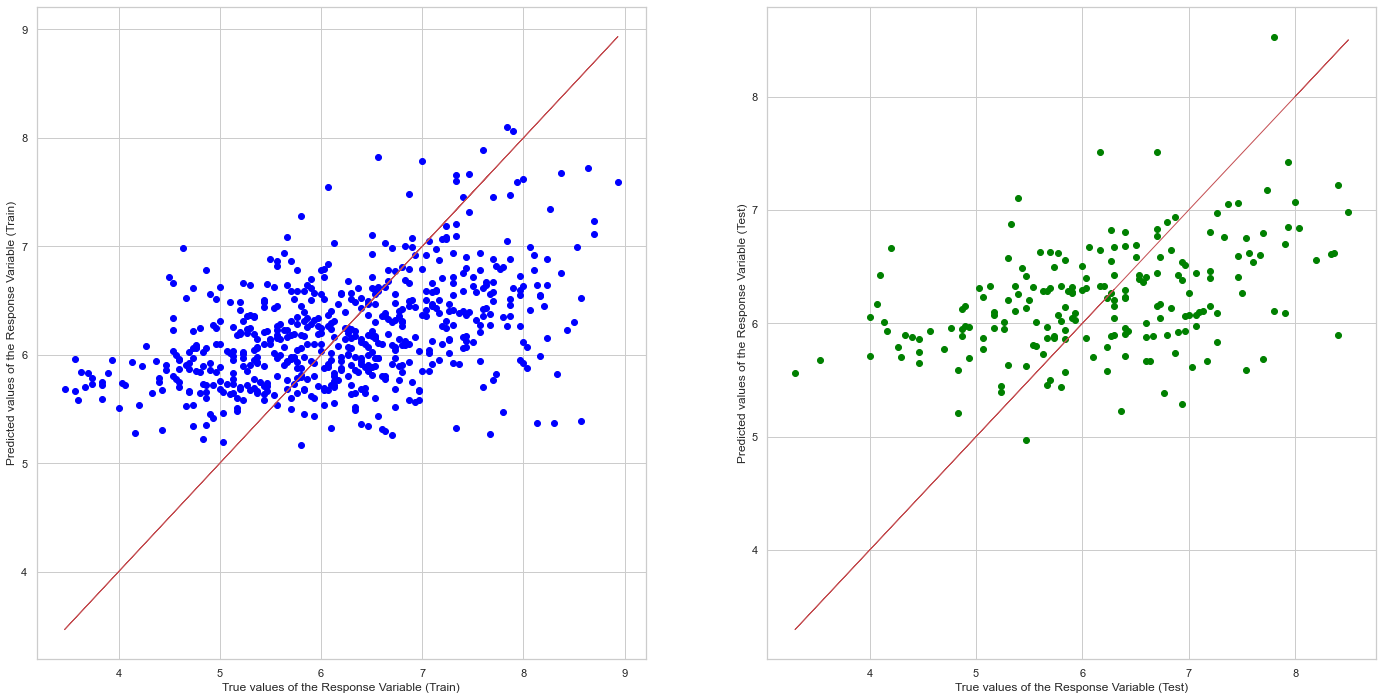

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.2057398868566298
Mean Squared Error (MSE) 	: 0.960645594888405

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.18186227832908264
Mean Squared Error (MSE) 	: 0.918663576191301



In [69]:
# Linear Regression using Train Data
linreg = LinearRegression()  # create the linear regression object
linreg.fit(X_train, y_train) # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

#### Prediction of Ratings

Let's predict the value of **Ratings** for a few specific movies -- *Solo: A Star Wars Story*, *Kingsman: The Golden Circle* and *Spirited Away* -- using the Regression Model derived above.   

In [70]:
# Extract Pokemons for Prediction
rating_pred = exploringData[exploringData["title"].isin(["Solo: A Star Wars Story", "Kingsman: The Golden Circle", "Spirited Away"])]
rating_pred

,original_language,release_date,runtime,title,Genre,Year,Ratings,Rated,general_rating,real_budget,real_profit,month of release
131,en,2018-05-15,135.0,Solo: A Star Wars Story,"Action, Adventure, Sci-Fi",2018,"[{'Source': 'Internet Movie Database', 'Value'...",PG-13,6.566667,2.500000e+08,1.429524e+08,5
137,en,2017-09-20,141.0,Kingsman: The Golden Circle,"Action, Adventure, Comedy, Crime, Thriller",2017,"[{'Source': 'Internet Movie Database', 'Value'...",R,6.033333,1.065402e+08,3.143987e+08,9
201,ja,2001-07-20,125.0,Spirited Away,"Animation, Adventure, Family, Fantasy, Mystery",2001,"[{'Source': 'Internet Movie Database', 'Value'...",PG,8.900000,2.693977e+07,3.628717e+08,7


In [71]:
# Extract Predictors for Prediction
X_pred = pd.DataFrame(rating_pred[predictors])

# Predict Response corresponding to Predictors
y_pred = linreg.predict(X_pred)

# Summarize the Actuals, Predictions and Errors
y_pred = pd.DataFrame(y_pred, columns = ["PredRatings"], index = rating_pred.index)
moviedata_acc = pd.concat([profit_pred[["title", "general_rating"]], y_pred], axis = 1)

y_errs = 100 * abs(moviedata_acc["general_rating"] - moviedata_acc["PredRatings"]) / moviedata_acc["general_rating"]
y_errs = pd.DataFrame(y_errs, columns = ["Error"], index = rating_pred.index)
moviedata_acc = pd.concat([moviedata_acc, y_errs], axis = 1)

moviedata_acc

,title,general_rating,PredRatings,Error
131,Solo: A Star Wars Story,6.566667,6.361830,3.119341
137,Kingsman: The Golden Circle,6.033333,6.948033,15.160760
201,Spirited Away,8.900000,6.717277,24.524976


In [72]:
MSE_train = mean_squared_error(y_train, y_train_pred)
StdE_pred = np.sqrt(len(y_train) * MSE_train/(len(y_train) - 2))

print("Mean Squared Error (MSE) \t:", MSE_train.round(2))
print("Pred Standard Error (SE) \t:", StdE_pred.round(2))

Mean Squared Error (MSE) 	: 0.96
Pred Standard Error (SE) 	: 0.98
